In [21]:
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
import warnings
import time
import os
from collections import defaultdict
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns

# Suppress warnings for cleaner output
warnings.filterwarnings("ignore", category=FutureWarning)

def load_and_prepare_data(file_path):
    """
    Step 1: Loads the basket data, applies efficient categorical types, 
    and builds mappings between product IDs and their internal matrix indices.
    """
    print("Step 1: Loading and preparing data...")
    if not os.path.exists(file_path):
        print(f"Error: File not found at {file_path}")
        return None, None, None
    
    df_baskets = pd.read_csv(file_path)
    df_baskets['order_id'] = df_baskets['order_id'].astype('category')
    df_baskets['product_id'] = df_baskets['product_id'].astype('category')
    
    product_ids = df_baskets['product_id'].cat.categories
    product_to_index = {product: i for i, product in enumerate(product_ids)}
    index_to_product = {i: product for product, i in product_to_index.items()}
    
    print("Data loaded and prepared successfully.")
    return df_baskets, product_to_index, index_to_product

def build_item_order_matrix(df_baskets):
    """
    Step 2: Builds a sparse item–order matrix (X) where X[i, j] = 1 
    if product i appears in order j. 
    This representation enables efficient similarity computations.
    """
    print("\nStep 2: Building the item-order sparse matrix...")
    n_products = len(df_baskets['product_id'].cat.categories)
    n_orders = len(df_baskets['order_id'].cat.categories)
    
    product_codes = df_baskets['product_id'].cat.codes.values
    order_codes = df_baskets['order_id'].cat.codes.values
    data = np.ones(len(df_baskets))
    
    item_order_matrix = csr_matrix((data, (product_codes, order_codes)), shape=(n_products, n_orders))
    
    print("Item-order matrix built successfully.")
    return item_order_matrix


def compute_topk_neighbors(item_order_matrix, index_to_product, K=10, batch_size=500):
    """
    Step 3 & 4: Efficiently computes Top-K similar items in batches using sparse 
    cosine similarity. Each product’s similarity scores are computed only for 
    relevant nonzero co-occurrences, reducing memory and runtime costs.
    """
    print("\nStep 3 & 4: Computing Top-K neighbors (optimized batch method)...")
    start_time = time.time()
    n_products = item_order_matrix.shape[0]
    top_k_similar_items = {}

    for start_idx in range(0, n_products, batch_size):
        end_idx = min(start_idx + batch_size, n_products)
        batch = item_order_matrix[start_idx:end_idx]
        
        # Compute sparse cosine similarity only for this batch
        sims = cosine_similarity(batch, item_order_matrix, dense_output=False)

        for i, row in enumerate(sims):
            global_i = start_idx + i
            product_id = index_to_product[global_i]
            row = row.toarray().ravel()

            # Exclude self-similarity
            row[global_i] = 0.0
            
            # Get top-K indices and scores
            if np.any(row):
                top_k_idx = np.argpartition(row, -K)[-K:]
                top_k_scores = row[top_k_idx]
                sort_order = np.argsort(top_k_scores)[::-1]
                final_indices = top_k_idx[sort_order]
                final_scores = top_k_scores[sort_order]
                top_k_similar_items[product_id] = [
                    {'product_id': index_to_product[idx], 'score': round(float(score), 4)}
                    for idx, score in zip(final_indices, final_scores)
                ]
            else:
                top_k_similar_items[product_id] = []

        if (end_idx % (5 * batch_size)) == 0 or end_idx == n_products:
            print(f"Processed {end_idx}/{n_products} items...")

    print(f"Top-K calculation done in {time.time() - start_time:.2f} seconds.")
    return top_k_similar_items


def save_neighbors_to_file(top_k_items, file_path):
    """
    Step 5: Saves the computed Top-K neighbor results to a CSV file for reuse. 
    Each row contains a product ID, its neighbor ID, and the similarity score.
    """
    print(f"\nSaving neighbors artifact to {file_path}...")
    rows = []
    for product_id, neighbors in top_k_items.items():
        for neighbor in neighbors:
            rows.append([product_id, neighbor['product_id'], neighbor['score']])
    
    df_neighbors = pd.DataFrame(rows, columns=['product_id', 'neighbor_id', 'score'])
    df_neighbors.to_csv(file_path, index=False)
    print("Artifact saved successfully.")

def get_candidate_items(user_recent_purchases, top_k_similar_items, num_recommendations=5):
    """
     Step 6: Generates candidate product recommendations for a user based on their 
    recent purchases. For each purchased item, it collects similar products 
    weighted by their similarity scores and returns the top-ranked candidates.
    """
    candidate_items = defaultdict(float)
    recent_set = set(user_recent_purchases)

    for product_id in user_recent_purchases:
        if product_id in top_k_similar_items:
            for item in top_k_similar_items[product_id]:
                candidate_product = item['product_id']
                score = item['score']

                if candidate_product in recent_set:
                    continue
                
                if score > candidate_items[candidate_product]:
                    candidate_items[candidate_product] = score

    sorted_candidates = sorted(candidate_items.items(), key=lambda x: x[1], reverse=True)
    return [item[0] for item in sorted_candidates[:num_recommendations]]

    # Step 6: Visualization helper

def visualize_topk_for_product(product_id, top_k_items):
    """
    Visualizes Top-K similar items for a given product ID using a horizontal bar plot.
    """
    if product_id not in top_k_items:
        print(f"No neighbors found for Product ID {product_id}")
        return

    neighbors = top_k_items[product_id]
    if not neighbors:
        print(f"No similarity data available for Product ID {product_id}")
        return

    labels = [str(n['product_id']) for n in neighbors]
    scores = [n['score'] for n in neighbors]

    plt.figure(figsize=(8, 5))
    plt.barh(labels[::-1], scores[::-1])
    plt.xlabel("Similarity Score")
    plt.ylabel("Neighbor Product ID")
    plt.title(f"Top-{len(neighbors)} Similar Items for Product {product_id}")
    plt.tight_layout()
    plt.show()


In [22]:
def main():
    """
    Main function to run the entire item–item similarity pipeline.
    Returns key data objects for later analysis or visualization.
    """
    # Step 1: Define file paths
    DATA_FILE_PATH = r"C:\Users\kthac\Desktop\Group_4419\item item similarity\item_item_basket.csv"
    NEIGHBORS_ARTIFACT_PATH = "top_k_neighbors.csv"
    
    # Load and prepare data
    df_baskets, product_to_index, index_to_product = load_and_prepare_data(DATA_FILE_PATH)
    if df_baskets is None:
        print("Data load failed. Exiting pipeline.")
        return None, None, None, None, None

    # Step 2: Build a sparse item–order matrix
    item_order_matrix = build_item_order_matrix(df_baskets)
    
    # Step 3 & 4: Compute Top-K item similarities
    top_k_items = compute_topk_neighbors(item_order_matrix, index_to_product, K=10)
    
    # Step 5: Save results to file
    save_neighbors_to_file(top_k_items, NEIGHBORS_ARTIFACT_PATH)
    
    # Step 6: Generate sample recommendations
    user_purchases = [13176, 21137]
    recommended_candidates = get_candidate_items(user_purchases, top_k_items, num_recommendations=5)
    
    print("\nSample user recommendations:")
    print(f"For user purchases {user_purchases}: {recommended_candidates}")
    
    print("\nPipeline completed successfully.")
    
    # Return all key objects for later analysis
    return df_baskets, item_order_matrix, top_k_items, product_to_index, index_to_product


In [23]:
df_baskets, item_order_matrix, top_k_items, product_to_index, index_to_product = main()


Step 1: Loading and preparing data...
Data loaded and prepared successfully.

Step 2: Building the item-order sparse matrix...
Item-order matrix built successfully.

Step 3 & 4: Computing Top-K neighbors (optimized batch method)...
Processed 2500/49677 items...
Processed 5000/49677 items...
Processed 7500/49677 items...
Processed 10000/49677 items...
Processed 12500/49677 items...
Processed 15000/49677 items...
Processed 17500/49677 items...
Processed 20000/49677 items...
Processed 22500/49677 items...
Processed 25000/49677 items...
Processed 27500/49677 items...
Processed 30000/49677 items...
Processed 32500/49677 items...
Processed 35000/49677 items...
Processed 37500/49677 items...
Processed 40000/49677 items...
Processed 42500/49677 items...
Processed 45000/49677 items...
Processed 47500/49677 items...
Processed 49677/49677 items...
Top-K calculation done in 214.98 seconds.

Saving neighbors artifact to top_k_neighbors.csv...
Artifact saved successfully.

Sample user recommendation

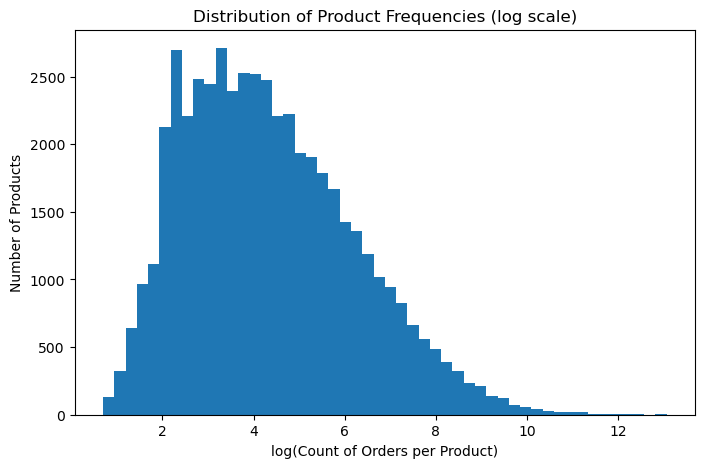

In [24]:
freq = np.asarray(df_baskets['product_id'].value_counts())
plt.figure(figsize=(8,5))
plt.hist(np.log1p(freq), bins=50)
plt.title("Distribution of Product Frequencies (log scale)")
plt.xlabel("log(Count of Orders per Product)")
plt.ylabel("Number of Products")
plt.show()


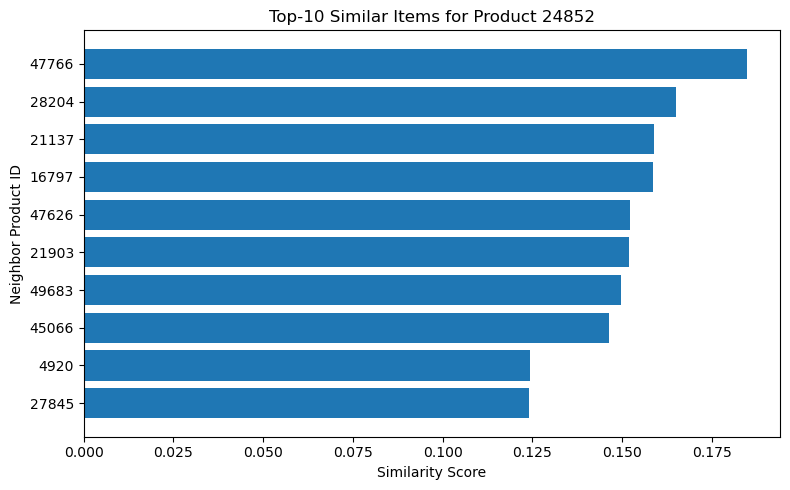

In [25]:
visualize_topk_for_product(24852, top_k_items)


# Step 1: Data Loading and Initial Preparation
This step handles data ingestion and initial memory optimization using pandas.

pd.read_csv() loads the basket data into a DataFrame.

.astype('category') is the key memory-saving step. Instead of storing product and order IDs as large integers or strings, converting them to the category dtype lets pandas internally map each unique ID to a small integer (.cat.codes). This dramatically reduces memory usage and makes indexing more efficient.

ID–Index Mapping: Two dictionaries (product_to_index and index_to_product) map original product_id values to their corresponding integer indices (0 to n_products − 1) and back. These mappings are essential for constructing the sparse matrix, which relies on zero-based numeric indices.

# Step 2: Creating the Item-Order Sparse Matrix
The goal is to represent which products appeared in which orders using a compact matrix form.

A dense (num_products × num_orders) NumPy array would be too large, so we use a compressed sparse row (CSR) matrix:

scipy.sparse.csr_matrix is chosen because it stores only nonzero entries and supports efficient matrix–vector and matrix–matrix operations, such as the dot product used later.

Construction:
csr_matrix((data, (rows, cols)), shape=...) builds the matrix from coordinate-style inputs:

rows: product indices (df_baskets['product_id'].cat.codes)

cols: order indices (df_baskets['order_id'].cat.codes)

data: an array of ones indicating that a product appears in an order

The result is a sparse binary matrix where X[i, j] = 1 if product i was part of order j.

# Step 3: Calculate Item-Item Similarity 
This is the computational core of the algorithm. It measures how strongly products are associated based on how often they appear together.

Co-occurrence Matrix:
The dot product item_order_matrix.dot(item_order_matrix.T) computes a (num_products × num_products) co-occurrence matrix. Each cell counts how many orders contained both items.

Memory Management:
A dense similarity matrix would require tens of gigabytes of RAM, so the calculation is processed in chunks to remain memory-safe.

Similarity Metric:
Similarity is based on normalized co-occurrence: 
$$\text{Similarity}(A, B) =\frac{\text{CoOccur}(A, B)}{\sqrt{\text{Count}(A)} \times \sqrt{\text{Count}(B)}}$$

The denominator is efficiently computed using NumPy’s outer product, avoiding explicit loops.

Sparse Construction:
Results are built incrementally into a LIL (List of Lists) sparse matrix, which allows fast row-by-row updates before being converted back to CSR format later.

# Step 4: Finding Top-K Similar Items
This step extracts the K most similar products for each item from the similarity matrix.

The matrix is converted from LIL to CSR format (.tocsr()), which allows fast row access.

Instead of using a full nearest-neighbor search (which would be slower and require a dense matrix), we use NumPy’s partial sorting:

np.argsort(row)[::-1] retrieves indices in descending order of similarity.

Slicing with [:K+1] selects the most similar K items (plus the item itself, which can later be excluded).

This approach is both fast and memory-efficient, ideal for large-scale recommender systems.

# Step 5: Generating Recommendations (Example Usage)
Finally, the precomputed similarities are used to produce recommendations for a user.

get_candidate_items() takes a user’s recent purchases and retrieves similar products from the Top-K lists.

Candidate Aggregation:
Each purchased item contributes a set of potential recommendations. A dictionary (candidate_items) accumulates all candidates and their highest similarity scores.

Duplicate Handling:
The check if candidate_product not in candidate_items or score > candidate_items[candidate_product] ensures that when a product is suggested by multiple items, only the strongest similarity score is kept.

Ranking and Output:
The dictionary is converted to a sorted list, returning the top-N recommended product IDs ranked by similarity.